In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers, models, metrics
import matplotlib.pyplot as plt

# Loading Datasets

In [2]:
cldt = pd.read_csv("../input/electrical-fault-detection-and-classification/classData.csv")
ddt = pd.read_csv("../input/electrical-fault-detection-and-classification/detect_dataset.csv")

# **Fault Classification**

# Extracting Features and Labels

In [3]:
cldt['fault_types'] = cldt['G'].astype('str') + cldt['C'].astype('str') + cldt['B'].astype('str') + cldt['A'].astype('str')

categories = ["NF", "LG", "LL", "LLG", "LLL", "LLLG"]
encode = {"fault_types":
         {
             "0000" : 0,
             "1001" : 1,
             "0110" : 2,
             "1011" : 3,
             "0111" : 4,
             "1111" : 5
         }}

cldt.replace(encode, inplace = True)

In [4]:
X = cldt.iloc[:, 4:-1]
X = X / X.max(axis = 0)
y = cldt.iloc[:, -1]
X.shape, y.shape
X

,Ia,Ib,Ic,Va,Vb,Vc
0,-0.170809,-0.010875,0.095199,0.673142,-0.211722,-0.446225
1,-0.379555,-0.085724,0.020337,0.525298,-0.196907,-0.315071
2,-0.567765,-0.196263,-0.089789,0.446346,-0.182044,-0.252304
3,-0.670561,-0.244647,-0.138573,0.395589,-0.167136,-0.217552
4,-0.726697,-0.251902,-0.146773,0.351960,-0.152186,-0.189915
...,...,...,...,...,...,...
7856,-0.074783,0.043217,0.027641,0.158600,-0.879186,0.762436
7857,-0.074344,0.042102,0.028311,0.174317,-0.884230,0.752122
7858,-0.073889,0.040986,0.028966,0.189986,-0.889048,0.741620
7859,-0.073419,0.039868,0.029608,0.205603,-0.893640,0.730932


In [5]:
X_final = np.array(X)
y_final = np.array(y)

# Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=15)
X_train.shape, y_train.shape, X_test.shape

((6288, 6), (6288,), (1573, 6))

# Function for model training

In [7]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Flatten
from keras import optimizers

In [8]:
def model_train(model, epochs, feature, label, summary):

    model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )
    if summary:
        print(model.summary())
    model.fit(
    feature,
    label,
    validation_split=0.2,
    batch_size=32,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        )
    ]
)

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def model_report(pred, label, report):
    # for classification report, use report = "classification"
    # for confusion matrix, use report = "confusion_matrix"
    p = []

    for i in range(label.shape[0]):
            p.append(np.argmax(pred[i]))

    y_truth = label.flatten().tolist()

    if report == "classification":
        print(classification_report(y_truth, p, target_names = categories))
        
    if report == "confusion_matrix":
        cm = confusion_matrix(y_truth, p)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=categories)
        disp.plot()
        plt.show()

# Defining Parameters

In [10]:
epochs = 150
patience = 10
output_shape = 6
input_shape = X.shape[1]
X_train.shape, y_train.shape

((6288, 6), (6288,))

# Model 1 (CNN)

In [11]:
def cnn_model():
    # Input Layer
    input_layer = Input(shape = (input_shape, 1))
    
    # Convolution Layer
    X = Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(input_layer)
    
    X = Conv1D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')(X)
    
    X = Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(X)
    
    X = Flatten()(X)
    # Dense Layers
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.3)(X)
    
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.2)(X)

    X = Dense(output_shape, activation = 'sigmoid')(X)
    
    model = Model(input_layer, X, name = 'cnn_model')
    return model

In [12]:
cnn = cnn_model()

2022-07-12 16:05:19.766724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 16:05:19.886007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 16:05:19.887227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 16:05:19.889610: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
model_train(cnn, epochs, X_train, y_train, summary = True)

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 64)             256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 128)            24704     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 32)             12320     
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               24704     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0 

2022-07-12 16:05:23.104184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-07-12 16:05:24.575964: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


158/158 [==============================] - 8s 6ms/step - loss: 0.9128 - accuracy: 0.6203 - val_loss: 0.5149 - val_accuracy: 0.7727
Epoch 2/150
158/158 [==============================] - 1s 5ms/step - loss: 0.4982 - accuracy: 0.7670 - val_loss: 0.3788 - val_accuracy: 0.7957
Epoch 3/150
158/158 [==============================] - 1s 4ms/step - loss: 0.4049 - accuracy: 0.8002 - val_loss: 0.4421 - val_accuracy: 0.7647
Epoch 4/150
158/158 [==============================] - 1s 5ms/step - loss: 0.3783 - accuracy: 0.8054 - val_loss: 0.3032 - val_accuracy: 0.8291
Epoch 5/150
158/158 [==============================] - 1s 5ms/step - loss: 0.3378 - accuracy: 0.8231 - val_loss: 0.3191 - val_accuracy: 0.8124
Epoch 6/150
158/158 [==============================] - 1s 4ms/step - loss: 0.3278 - accuracy: 0.8209 - val_loss: 0.3212 - val_accuracy: 0.8291
Epoch 7/150
158/158 [==============================] - 1s 4ms/step - loss: 0.3124 - accuracy: 0.8245 - val_loss: 0.2932 - val_accuracy: 0.8227
Epoch 8/150

In [14]:
pred = cnn.predict(X_test)
model_report(pred, y_test, report = "classification")

              precision    recall  f1-score   support

          NF       1.00      1.00      1.00       455
          LG       0.97      1.00      0.99       238
          LL       1.00      1.00      1.00       202
         LLG       1.00      0.97      0.98       216
         LLL       1.00      0.12      0.21       233
        LLLG       0.53      1.00      0.69       229

    accuracy                           0.86      1573
   macro avg       0.92      0.85      0.81      1573
weighted avg       0.93      0.86      0.83      1573



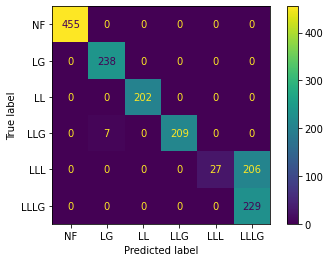

In [15]:
model_report(pred, y_test, report = "confusion_matrix")

# Model - 2 (RNN - GRU model)

In [16]:
inputs = Input(shape=(input_shape,))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = layers.GRU(2048, return_sequences=True)(expand_dims)

gru = layers.GRU(1024, return_sequences=True)(gru)

flatten = Flatten()(gru)

outputs = Dense(output_shape, activation='softmax')(flatten)


model_gru = Model(inputs=inputs, outputs=outputs)

In [17]:
model_train(model_gru, epochs, X_train, y_train, summary = True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 6, 1)              0         
_________________________________________________________________
gru (GRU)                    (None, 6, 2048)           12601344  
_________________________________________________________________
gru_1 (GRU)                  (None, 6, 1024)           9443328   
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 36870     
Total params: 22,081,542
Trainable params: 22,081,542
Non-trainable params: 0
_________________________________________________

In [18]:
pred = model_gru.predict(X_test)
model_report(pred, y_test, report = "classification")

              precision    recall  f1-score   support

          NF       1.00      1.00      1.00       455
          LG       0.96      1.00      0.98       238
          LL       0.99      0.99      0.99       202
         LLG       1.00      0.96      0.98       216
         LLL       0.52      0.49      0.50       233
        LLLG       0.51      0.53      0.52       229

    accuracy                           0.85      1573
   macro avg       0.83      0.83      0.83      1573
weighted avg       0.85      0.85      0.85      1573



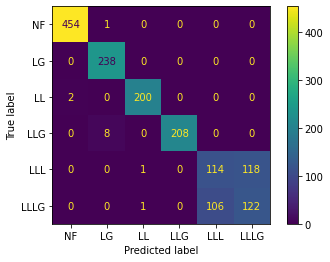

In [19]:
model_report(pred, y_test, report = "confusion_matrix")

# Model - 3 (RNN - LSTM model)

In [20]:
from keras.layers import LSTM

inputs = Input(shape=(input_shape,))

expand_dims = tf.expand_dims(inputs, axis=2)

lstm = LSTM(1024, return_sequences=True)(expand_dims)
lstm = LSTM(2048, return_sequences=True)(expand_dims)
flatten = Flatten()(lstm)

outputs = Dense(output_shape, activation='softmax')(flatten)


model_lstm = Model(inputs=inputs, outputs=outputs)

In [21]:
model_train(model_lstm, epochs, X_train, y_train, summary = True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
tf.expand_dims_1 (TFOpLambda (None, 6, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 2048)           16793600  
_________________________________________________________________
flatten_2 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 73734     
Total params: 16,867,334
Trainable params: 16,867,334
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
158/158 [==============================] - 4s 15ms/step - loss: 1.3751 - accuracy: 0.4441 - val_

In [22]:
pred = model_lstm.predict(X_test)
model_report(pred, y_test, report = "classification")

              precision    recall  f1-score   support

          NF       1.00      1.00      1.00       455
          LG       0.98      1.00      0.99       238
          LL       0.99      1.00      0.99       202
         LLG       0.98      0.98      0.98       216
         LLL       0.51      0.23      0.32       233
        LLLG       0.49      0.76      0.60       229

    accuracy                           0.85      1573
   macro avg       0.83      0.83      0.81      1573
weighted avg       0.85      0.85      0.83      1573



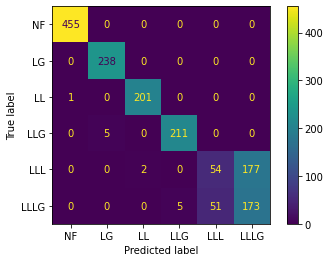

In [23]:
model_report(pred, y_test, report = "confusion_matrix")

# Performance Analysis of different Models

In [24]:
performance1 = cnn.evaluate(X_test, y_test)
performance2 = model_gru.evaluate(X_test, y_test)
performance3 = model_lstm.evaluate(X_test, y_test)

50/50 [==============================] - 0s 5ms/step - loss: 0.2133 - accuracy: 0.8468


In [25]:
print("CNN model accuracy:", performance1[1] * 100, "%")
print("GRU model accuracy", performance2[1] * 100, "%")
print("LSTM model accuracy", performance3[1] * 100, "%")

CNN model accuracy: 86.45899295806885 %
GRU model accuracy 84.93325114250183 %
LSTM model accuracy 84.67895984649658 %


# **Fault Detection**

# Feature Extraction

In [26]:
Xd = ddt.iloc[:, 1:7]
Xd = Xd / Xd.max(axis = 0)
yd = ddt.iloc[:, 0]

In [27]:
Xd

,Ia,Ib,Ic,Va,Vb,Vc
0,-0.192463,0.010361,0.178916,0.089348,-1.051039,0.995377
1,-0.138004,0.006932,0.128781,0.167251,-1.001173,0.865118
2,-0.101792,0.004286,0.095806,0.231241,-0.964009,0.763266
3,-0.090213,0.002696,0.085996,0.256242,-0.959165,0.733199
4,-0.072127,0.000664,0.070228,0.295888,-0.942069,0.675799
...,...,...,...,...,...,...
11996,-0.074783,0.043217,0.027641,0.154823,-0.879186,0.752327
11997,-0.074344,0.042102,0.028311,0.170166,-0.884230,0.742150
11998,-0.073889,0.040986,0.028966,0.185462,-0.889048,0.731787
11999,-0.073419,0.039868,0.029608,0.200707,-0.893640,0.721242


In [28]:
X_ddt = np.array(Xd)
y_ddt = np.array(yd)

# Defining Parameters

In [29]:
output_shape = 2
input_shape = Xd.shape[1]
categories = ["No Fault", "Fault"]
Xd.shape, yd.shape

((12001, 6), (12001,))

# Train Test Split

In [30]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_ddt, y_ddt, test_size=0.2, random_state=15)
X_train_d.shape, y_train_d.shape

((9600, 6), (9600,))

# CNN model

In [31]:
model_train(cnn, epochs, X_train_d, y_train_d, summary = False)

Epoch 1/150
240/240 [==============================] - 2s 5ms/step - loss: 0.2777 - accuracy: 0.9589 - val_loss: 0.0301 - val_accuracy: 0.9896
Epoch 2/150
240/240 [==============================] - 1s 4ms/step - loss: 0.0265 - accuracy: 0.9914 - val_loss: 0.0346 - val_accuracy: 0.9927
Epoch 3/150
240/240 [==============================] - 1s 4ms/step - loss: 0.0182 - accuracy: 0.9944 - val_loss: 0.0164 - val_accuracy: 0.9911
Epoch 4/150
240/240 [==============================] - 1s 4ms/step - loss: 0.0156 - accuracy: 0.9947 - val_loss: 0.0155 - val_accuracy: 0.9927
Epoch 5/150
240/240 [==============================] - 1s 4ms/step - loss: 0.0165 - accuracy: 0.9941 - val_loss: 0.0251 - val_accuracy: 0.9917
Epoch 6/150
240/240 [==============================] - 1s 4ms/step - loss: 0.0200 - accuracy: 0.9923 - val_loss: 0.0151 - val_accuracy: 0.9932
Epoch 7/150
240/240 [==============================] - 1s 4ms/step - loss: 0.0147 - accuracy: 0.9937 - val_loss: 0.0138 - val_accuracy: 0.9922

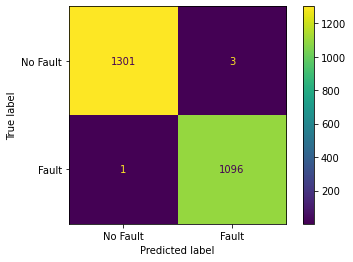

In [32]:
pred = cnn.predict(X_test_d)
model_report(pred, y_test_d, report = "confusion_matrix")

In [33]:
model_report(pred, y_test_d, report = "classification")

              precision    recall  f1-score   support

    No Fault       1.00      1.00      1.00      1304
       Fault       1.00      1.00      1.00      1097

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401



# GRU Model

In [34]:
model_train(model_gru, epochs, X_train_d, y_train_d, summary = False)

Epoch 1/150
240/240 [==============================] - 7s 19ms/step - loss: 0.1390 - accuracy: 0.9733 - val_loss: 0.0617 - val_accuracy: 0.9833
Epoch 2/150
240/240 [==============================] - 3s 14ms/step - loss: 0.0276 - accuracy: 0.9922 - val_loss: 0.0257 - val_accuracy: 0.9906
Epoch 3/150
240/240 [==============================] - 3s 14ms/step - loss: 0.0214 - accuracy: 0.9935 - val_loss: 0.0601 - val_accuracy: 0.9740
Epoch 4/150
240/240 [==============================] - 3s 14ms/step - loss: 0.0326 - accuracy: 0.9898 - val_loss: 0.0476 - val_accuracy: 0.9849
Epoch 5/150
240/240 [==============================] - 3s 14ms/step - loss: 0.0214 - accuracy: 0.9927 - val_loss: 0.0254 - val_accuracy: 0.9906
Epoch 6/150
240/240 [==============================] - 3s 14ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0218 - val_accuracy: 0.9932
Epoch 7/150
240/240 [==============================] - 3s 14ms/step - loss: 0.0229 - accuracy: 0.9908 - val_loss: 0.0401 - val_accuracy:

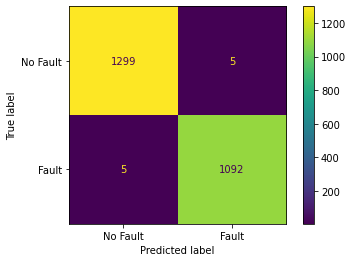

In [35]:
pred = model_gru.predict(X_test_d)
model_report(pred, y_test_d, report = "confusion_matrix")

In [36]:
model_report(pred, y_test_d, report = "classification")

              precision    recall  f1-score   support

    No Fault       1.00      1.00      1.00      1304
       Fault       1.00      1.00      1.00      1097

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401



# LSTM Model

In [37]:
model_train(model_lstm, epochs, X_train_d, y_train_d, summary = True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
tf.expand_dims_1 (TFOpLambda (None, 6, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 2048)           16793600  
_________________________________________________________________
flatten_2 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 73734     
Total params: 16,867,334
Trainable params: 16,867,334
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
240/240 [==============================] - 4s 12ms/step - loss: 0.2407 - accuracy: 0.9592 - val_

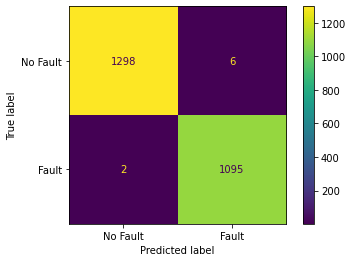

In [38]:
pred = model_lstm.predict(X_test_d)
model_report(pred, y_test_d, report = "confusion_matrix")

In [39]:
model_report(pred, y_test_d, report = "classification")

              precision    recall  f1-score   support

    No Fault       1.00      1.00      1.00      1304
       Fault       0.99      1.00      1.00      1097

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401



# Performance Analysis of different models

In [40]:
performance1 = cnn.evaluate(X_test_d, y_test_d)
performance2 = model_gru.evaluate(X_test_d, y_test_d)
performance3 = model_lstm.evaluate(X_test_d, y_test_d)

76/76 [==============================] - 1s 6ms/step - loss: 0.0061 - accuracy: 0.9967


In [41]:
print("CNN model accuracy:", performance1[1] * 100, "%")
print("GRU model accuracy", performance2[1] * 100, "%")
print("LSTM model accuracy", performance3[1] * 100, "%")

CNN model accuracy: 99.83340501785278 %
GRU model accuracy 99.58350658416748 %
LSTM model accuracy 99.66680407524109 %
